**Importing necessary libraries and parsing the health data, creating a data frame to prevent further parsing processes.**

File parsed successfully with recovery mode.


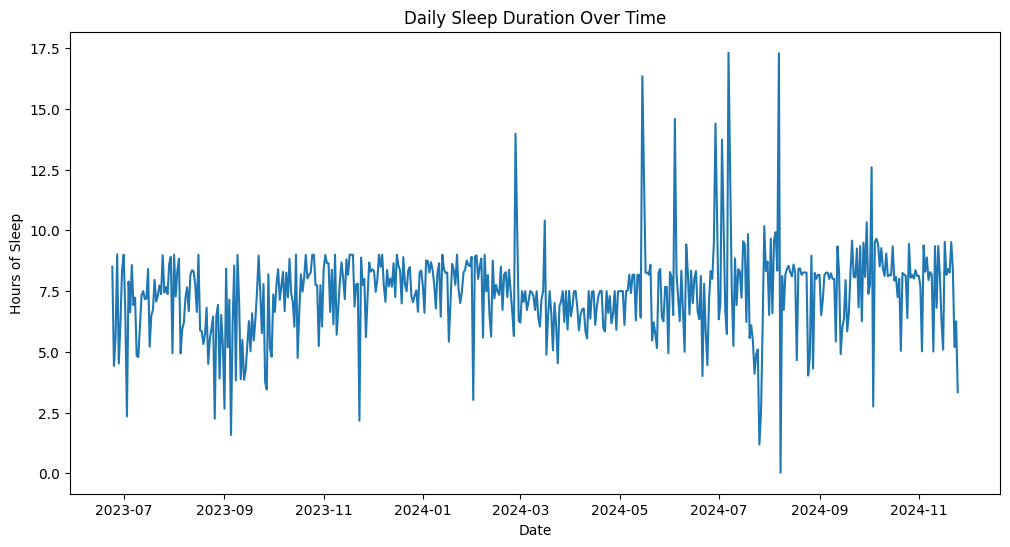

In [3]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lxml import etree

# Load and parse the export.xml file with error recovery
export_xml_path = '/content/export.xml'
try:
    with open(export_xml_path, 'rb') as file:
        tree = etree.parse(file, etree.XMLParser(recover=True))
        root = tree.getroot()
        print("File parsed successfully with recovery mode.")
except etree.XMLSyntaxError as e:
    print(f"Error parsing XML: {e}")

# Prepare a list to collect sleep data
sleep_data = []

# Extract SleepAnalysis records
def parse_date(date_str):
    from datetime import datetime
    return datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S %z")

for record in root.findall('Record'):
    if record.get('type') == 'HKCategoryTypeIdentifierSleepAnalysis':
        start_date = parse_date(record.get('startDate'))
        end_date = parse_date(record.get('endDate'))
        duration_hours = (end_date - start_date).total_seconds() / 3600
        sleep_data.append({
            'start_date': start_date,
            'end_date': end_date,
            'duration_hours': duration_hours
        })

# Create a DataFrame
sleep_df = pd.DataFrame(sleep_data)
sleep_df['date'] = sleep_df['start_date'].dt.date

# Aggregate sleep duration per day
daily_sleep = sleep_df.groupby('date')['duration_hours'].sum().reset_index()

# Prepare for visualization
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_sleep, x='date', y='duration_hours')
plt.title('Daily Sleep Duration Over Time')
plt.xlabel('Date')
plt.ylabel('Hours of Sleep')
plt.show()

# Save the DataFrame for further analysis without re-parsing
sleep_df.to_csv('sleep_data_prepared.csv', index=False)


**Utilizing the preprocessed data**

<ipython-input-39-7af06b866c88>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sleep_df_2024['is_exam'] = sleep_df_2024['date'].isin(exam_dates_2024)


U-statistic (2024): 1.0, P-value: 3.6230158702181363e-07
U-statistic (2023): 633.5, P-value: 0.7072981315804217


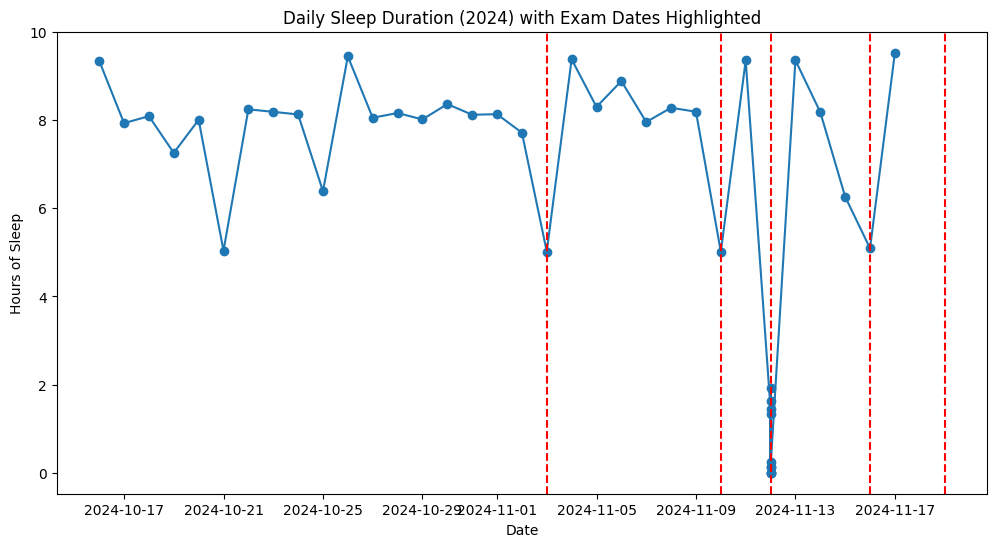

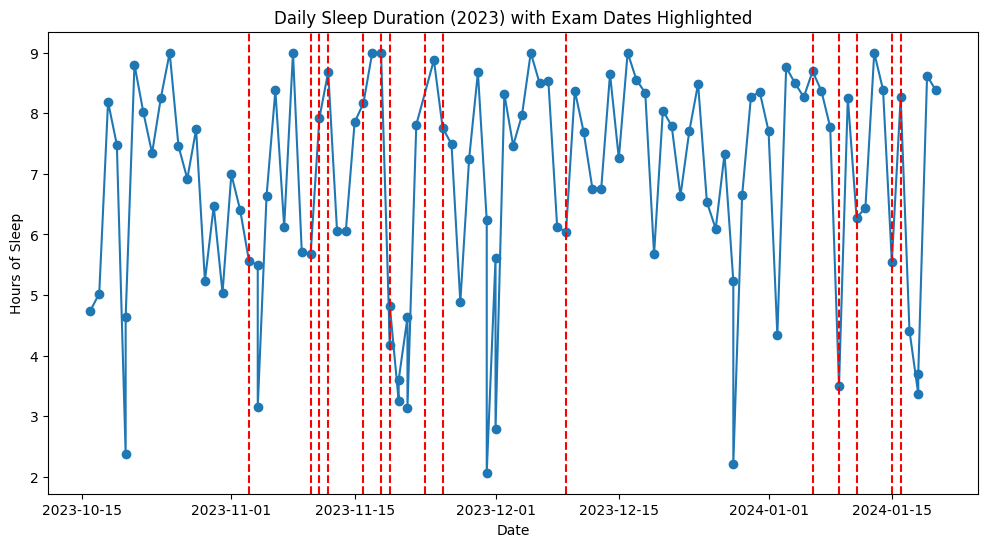

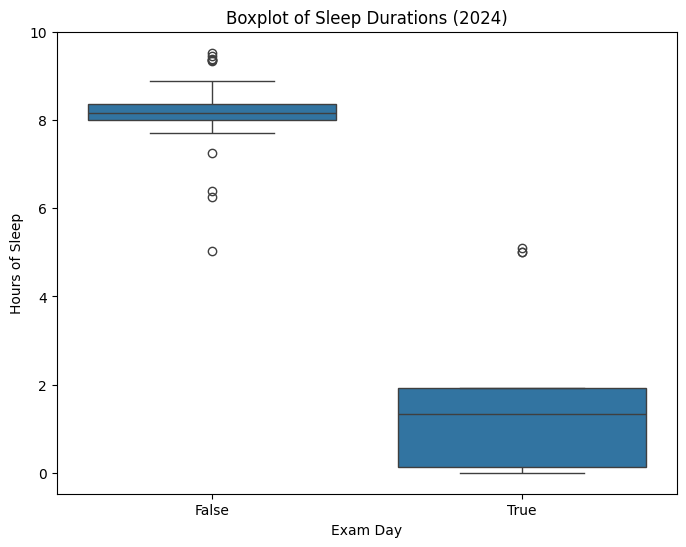

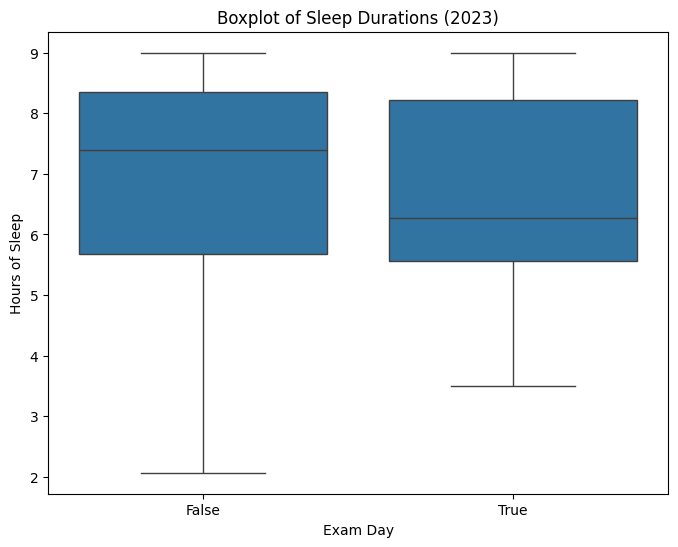

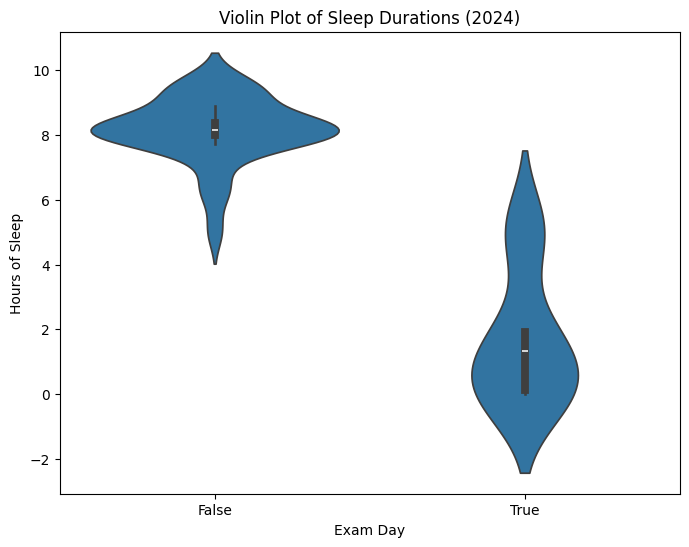

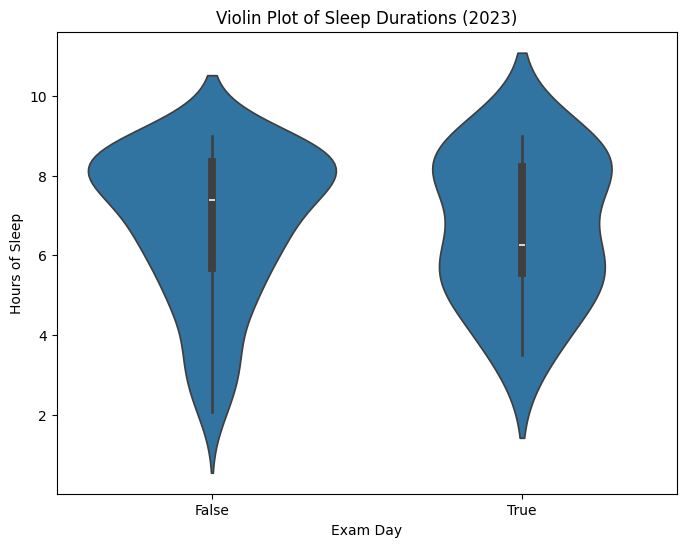

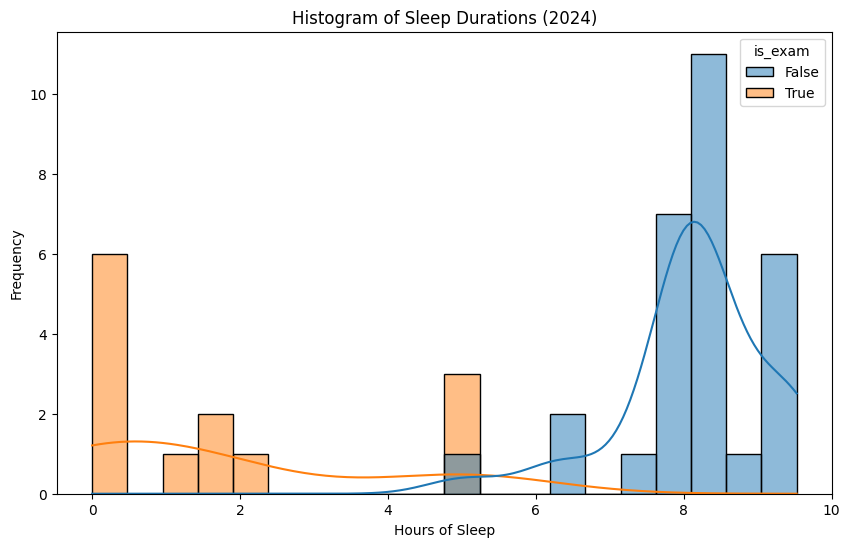

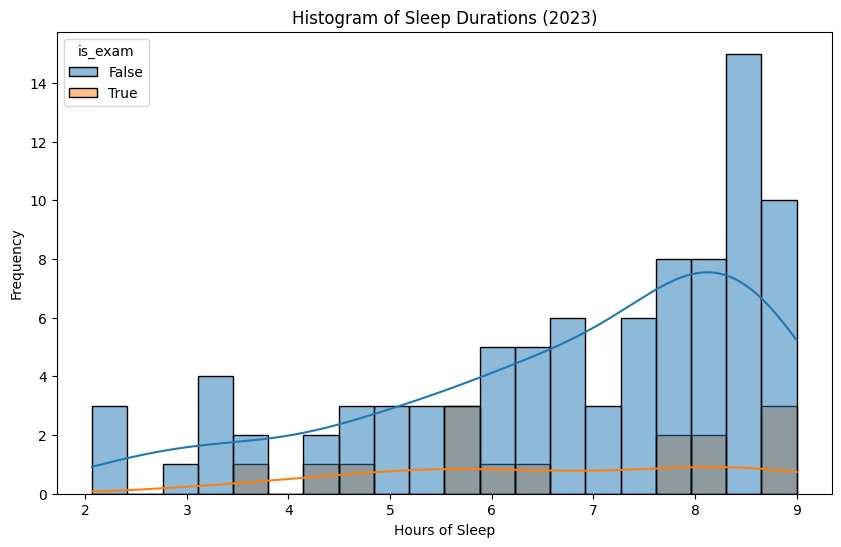

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Load the previously prepared sleep data
sleep_df = pd.read_csv('sleep_data_prepared.csv')

# Convert 'date' back to datetime for proper plotting
sleep_df['date'] = pd.to_datetime(sleep_df['date'])

# Filter the time periods of interest separately
sleep_df_2024 = sleep_df[(sleep_df['date'] > pd.to_datetime('2024-10-15')) & (sleep_df['date'] <= pd.to_datetime('2024-11-17'))]
sleep_df_2023 = sleep_df[(sleep_df['date'] > pd.to_datetime('2023-10-15')) & (sleep_df['date'] <= pd.to_datetime('2024-01-20'))]

# Eliminate sleep durations less than 2 hours for 2023
sleep_df_2023 = sleep_df_2023[sleep_df_2023['duration_hours'] >= 2]

# List of exam dates for both periods
exam_dates_2024 = [
    pd.to_datetime('2024-11-03'), pd.to_datetime('2024-11-10'), pd.to_datetime('2024-11-12'),
    pd.to_datetime('2024-11-16'), pd.to_datetime('2024-11-19')
]

exam_dates_2023 = [
    pd.to_datetime('2023-11-03'), pd.to_datetime('2023-11-10'), pd.to_datetime('2023-11-12'),
    pd.to_datetime('2023-11-16'), pd.to_datetime('2023-11-19'), pd.to_datetime('2023-11-18'),
    pd.to_datetime('2023-11-23'), pd.to_datetime('2023-11-25'), pd.to_datetime('2023-11-11'),
    pd.to_datetime('2023-12-09'), pd.to_datetime('2024-01-06'), pd.to_datetime('2024-01-09'),
    pd.to_datetime('2024-01-11'), pd.to_datetime('2024-01-15'), pd.to_datetime('2024-01-16')
]

# Add a column indicating whether the day is an exam date
sleep_df_2024['is_exam'] = sleep_df_2024['date'].isin(exam_dates_2024)
sleep_df_2023['is_exam'] = sleep_df_2023['date'].isin(exam_dates_2023)

# Perform Mann-Whitney U Test separately for both periods
from scipy.stats import mannwhitneyu

# Period 1: 2024
exam_days_2024 = sleep_df_2024[sleep_df_2024['is_exam'] == True]['duration_hours']
non_exam_days_2024 = sleep_df_2024[sleep_df_2024['is_exam'] == False]['duration_hours']

u_stat_2024, p_value_2024 = mannwhitneyu(exam_days_2024, non_exam_days_2024, alternative='two-sided')
print(f'U-statistic (2024): {u_stat_2024}, P-value: {p_value_2024}')

# Period 2: 2023
exam_days_2023 = sleep_df_2023[sleep_df_2023['is_exam'] == True]['duration_hours']
non_exam_days_2023 = sleep_df_2023[sleep_df_2023['is_exam'] == False]['duration_hours']

u_stat_2023, p_value_2023 = mannwhitneyu(exam_days_2023, non_exam_days_2023, alternative='two-sided')
print(f'U-statistic (2023): {u_stat_2023}, P-value: {p_value_2023}')

# Visualization: Line chart for both periods
for df, exam_dates, year in [(sleep_df_2024, exam_dates_2024, '2024'), (sleep_df_2023, exam_dates_2023, '2023')]:
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df['duration_hours'], marker='o', linestyle='-')
    for exam_date in exam_dates:
        plt.axvline(x=exam_date, color='red', linestyle='--')
    plt.title(f'Daily Sleep Duration ({year}) with Exam Dates Highlighted')
    plt.xlabel('Date')
    plt.ylabel('Hours of Sleep')
    plt.show()

# Boxplot for both periods
for df, year in [(sleep_df_2024, '2024'), (sleep_df_2023, '2023')]:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='is_exam', y='duration_hours', data=df)
    plt.title(f'Boxplot of Sleep Durations ({year})')
    plt.xlabel('Exam Day')
    plt.ylabel('Hours of Sleep')
    plt.show()

# Violin plot for both periods
for df, year in [(sleep_df_2024, '2024'), (sleep_df_2023, '2023')]:
    plt.figure(figsize=(8, 6))
    sns.violinplot(x='is_exam', y='duration_hours', data=df)
    plt.title(f'Violin Plot of Sleep Durations ({year})')
    plt.xlabel('Exam Day')
    plt.ylabel('Hours of Sleep')
    plt.show()

# Histogram for both periods
for df, year in [(sleep_df_2024, '2024'), (sleep_df_2023, '2023')]:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='duration_hours', hue='is_exam', kde=True, bins=20)
    plt.title(f'Histogram of Sleep Durations ({year})')
    plt.xlabel('Hours of Sleep')
    plt.ylabel('Frequency')
    plt.show()




**Exam dates explicitly shown as vertical red lines.**

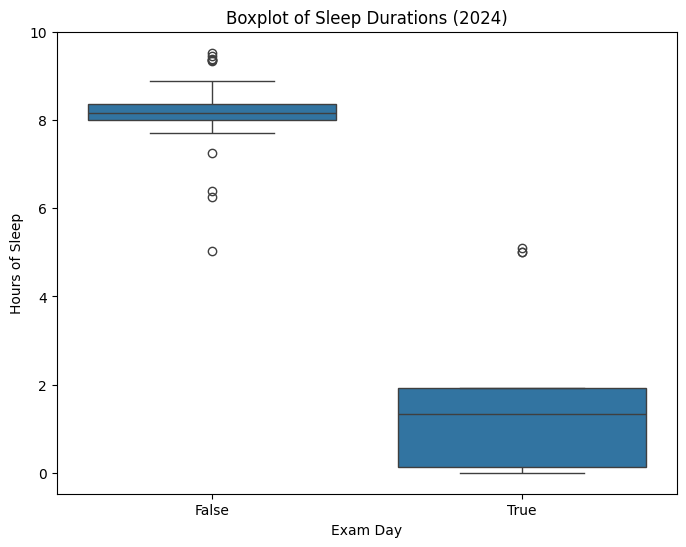

In [35]:
# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_exam', y='duration_hours', data=sleep_df_2024)
plt.title('Boxplot of Sleep Durations (2024)')
plt.xlabel('Exam Day')
plt.ylabel('Hours of Sleep')
plt.show()

**As shown in the box plot, I frequently sleep 8-10 hours, when there is no exam tomorrow :D**

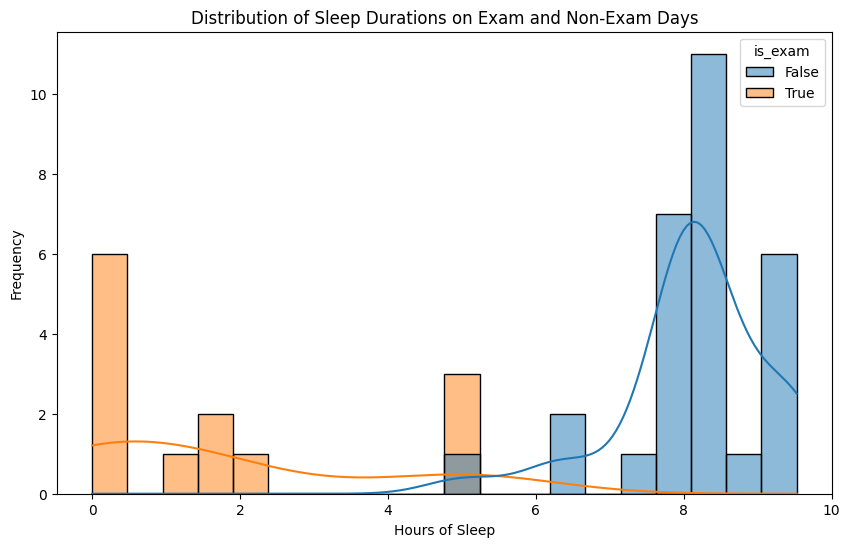

In [24]:
# Visualization 3: Histogram of sleep durations
plt.figure(figsize=(10, 6))
sns.histplot(data=sleep_df, x='duration_hours', hue='is_exam', kde=True, bins=20)
plt.title('Distribution of Sleep Durations on Exam and Non-Exam Days')
plt.xlabel('Hours of Sleep')
plt.ylabel('Frequency')
plt.show()


**Frequency of 8-10 hours sleep larger than 6 to 2 hours.**

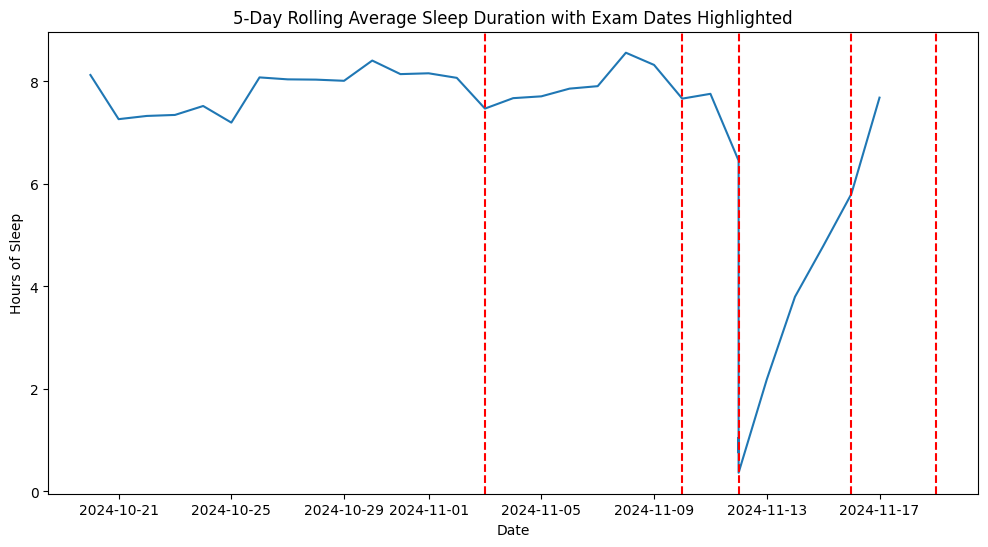

In [25]:
# Visualization 4: Rolling average sleep duration to observe trends
sleep_df['rolling_avg'] = sleep_df['duration_hours'].rolling(window=5).mean()
plt.figure(figsize=(12, 6))
plt.plot(sleep_df['date'], sleep_df['rolling_avg'], marker='', linestyle='-')
for exam_date in exam_dates:
    plt.axvline(x=exam_date, color='red', linestyle='--')
plt.title('5-Day Rolling Average Sleep Duration with Exam Dates Highlighted')
plt.xlabel('Date')
plt.ylabel('Hours of Sleep')
plt.show()

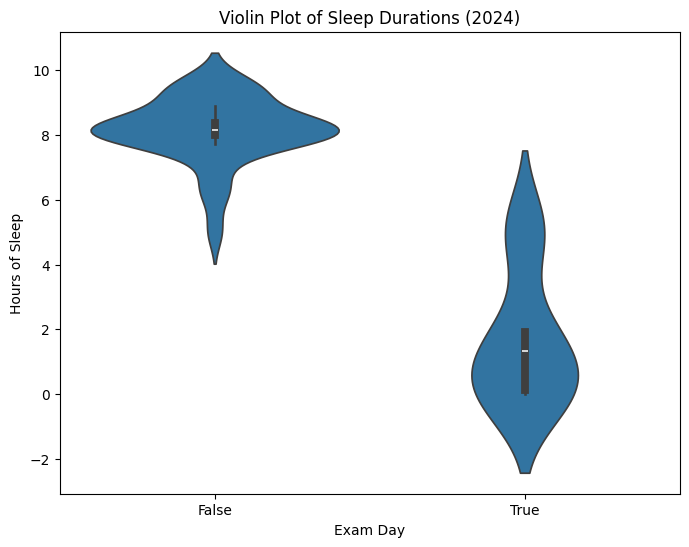

In [36]:

# Violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(x='is_exam', y='duration_hours', data=sleep_df_2024)
plt.title('Violin Plot of Sleep Durations (2024)')
plt.xlabel('Exam Day')
plt.ylabel('Hours of Sleep')
plt.show()

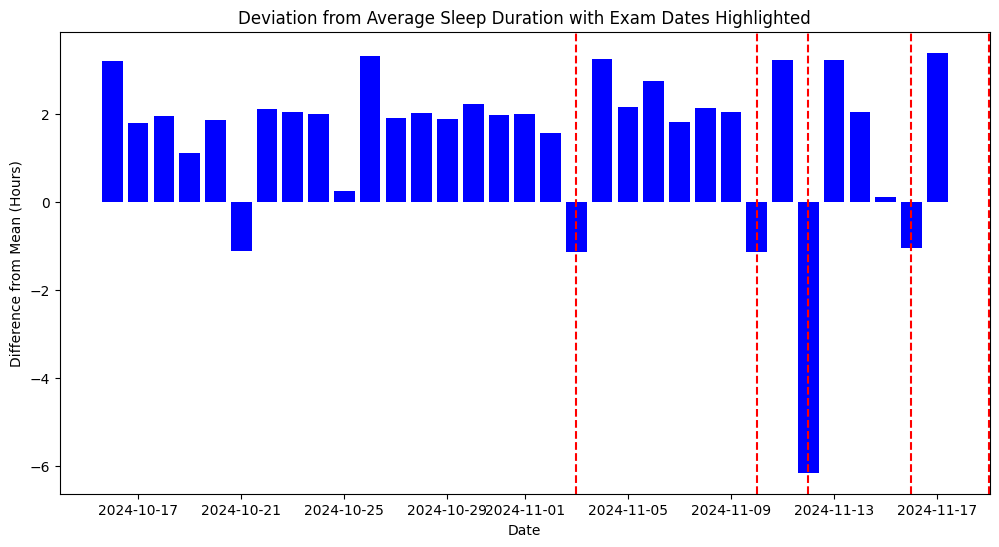

In [27]:
# Visualization 6: Sleep duration difference from mean
mean_sleep = sleep_df['duration_hours'].mean()
sleep_df['difference_from_mean'] = sleep_df['duration_hours'] - mean_sleep
plt.figure(figsize=(12, 6))
plt.bar(sleep_df['date'], sleep_df['difference_from_mean'], color='blue')
for exam_date in exam_dates:
    plt.axvline(x=exam_date, color='red', linestyle='--')
plt.title('Deviation from Average Sleep Duration with Exam Dates Highlighted')
plt.xlabel('Date')
plt.ylabel('Difference from Mean (Hours)')
plt.show()

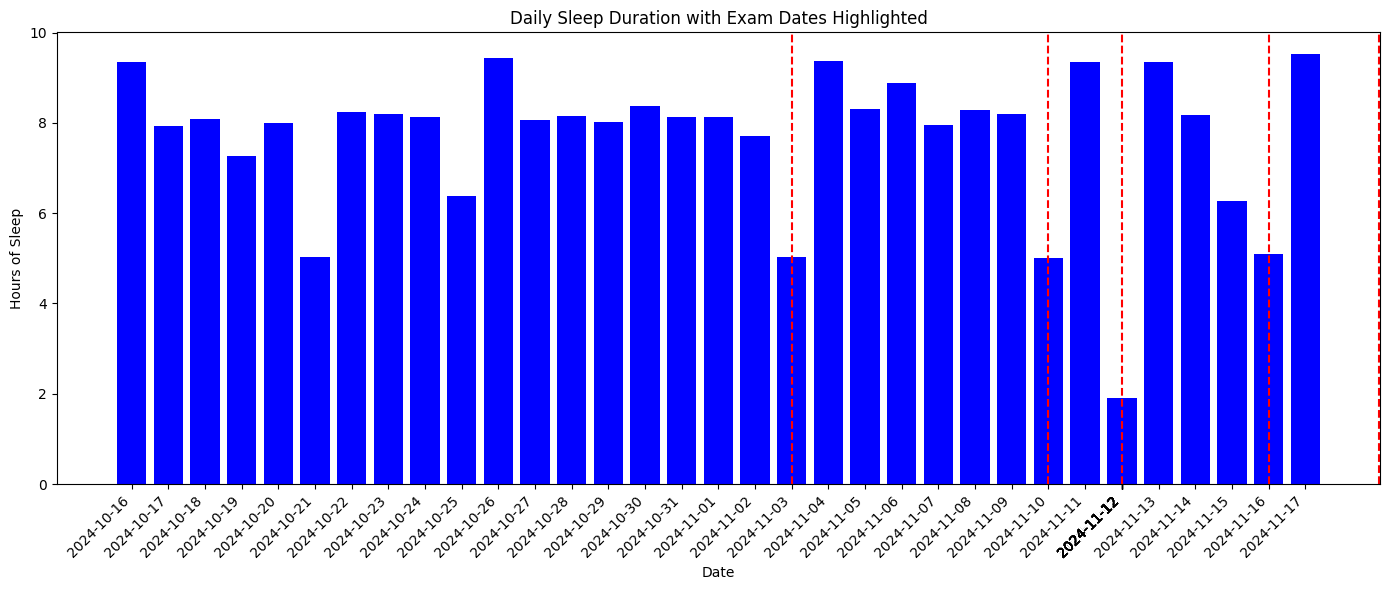

In [28]:
# Visualization: Bar plot showing each day labeled with vertical lines for exam dates
plt.figure(figsize=(14, 6))
plt.bar(sleep_df['date'], sleep_df['duration_hours'], color='blue')
plt.title('Daily Sleep Duration with Exam Dates Highlighted')
plt.xlabel('Date')
plt.ylabel('Hours of Sleep')
plt.xticks(sleep_df['date'], rotation=45, ha='right')

# Adding vertical lines for exam dates
for exam_date in exam_dates:
    plt.axvline(x=exam_date, color='red', linestyle='--')
plt.tight_layout()
plt.show()
